#### Install library
###### ライブラリをインストールする
https://github.com/Quang-Vinh/matrix-factorization

In [1]:
!pip install -q matrix_factorization

#### Import libraries
###### ライブラリをインストールする

In [19]:
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

#### Load movie data from movielens　100k
###### Movielens-100kのデータをロードする
  - X: index, user_id, item_id
  - y: index, rating

In [25]:
# Movie data found here https://grouplens.org/datasets/movielens/
cols = ["user_id", "item_id", "rating", "timestamp"]
movie_data = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.data", names=cols, sep="\t", usecols=[0, 1, 2], engine="python")

X = movie_data[["user_id", "item_id"]]
y = movie_data["rating"]

movie_data[["item_id","rating"]]

,item_id,rating
0,242,3
1,302,3
2,377,1
3,51,2
4,346,1
...,...,...
99995,476,3
99996,204,5
99997,1090,1
99998,225,2


In [108]:
title_data = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.item", names=["all_data"], sep="\t", engine="python", encoding='latin-1')
title_data = title_data['all_data'].str.split('|', expand=True)
title_data = title_data.loc[:, [0, 1]]
title_data = title_data.rename(columns={0: 'item_id', 1: 'title'})

#### Prepare data form online learning
###### オンライン学習のためにデータを準備する
  fac_new_users : Fraction of users for testing（テストデータの割合）

In [5]:
# Prepare data for online learning
(
    X_train_initial,
    y_train_initial,
    X_train_update,
    y_train_update,
    X_test_update,
    y_test_update,
) = train_update_test_split(movie_data, frac_new_users=0.2)
# print(movie_data.head(10))

#### Training
###### モデルをトレーニングする
  1. Generate instance of KernelMF class（Karnelクラスのインスタンスを生成）
  2. Fitting model（モデルをトレーニングする）　　

###### Kernelクラスの引数について
        n_epochs: エポック数、1つの訓練データを何回繰り返して学習させるかの数
        n_factors: 行列PおよびQの潜在因子数
        verbose: フィッティング時の冗長性、フィッティングモデルを印刷する場合は1、しない場合は0
        lr: 勾配最適化ステップの学習率アルファ
        reg: 正則化パラメータラムダ

In [6]:
epochs = 10

In [7]:
### Initial training
    ## KernelMFクラスのインスタンスを生成 
    # 詳しくは、https://github.com/Quang-Vinh/matrix-factorization/blob/master/matrix_factorization/kernel_matrix_factorization.py
matrix_fact = KernelMF(n_epochs=epochs, n_factors=100, verbose=1, lr=0.001, reg=0.005)
    ##  確率的勾配法を用いて行列分解をし、PおよびQ行列に分解
        # 引数について
        # X_train_initail: 列User_id、行Item_id
        # Y_train_initial: 評価
matrix_fact.fit(X_train_initial, y_train_initial)

Epoch  1 / 10  -  train_rmse: 1.0693487692160029
Epoch  2 / 10  -  train_rmse: 1.0365999805213837
Epoch  3 / 10  -  train_rmse: 1.0138811472232785
Epoch  4 / 10  -  train_rmse: 0.9971929481833647
Epoch  5 / 10  -  train_rmse: 0.9842782253879215
Epoch  6 / 10  -  train_rmse: 0.9738739685094109
Epoch  7 / 10  -  train_rmse: 0.9652012037623473
Epoch  8 / 10  -  train_rmse: 0.9577635296641939
Epoch  9 / 10  -  train_rmse: 0.9512497027125905
Epoch  10 / 10  -  train_rmse: 0.9454406478720215


KernelMF(gamma=0.01, lr=0.001, n_epochs=10, reg=0.005)

##### トレーニングデータに無いユーザデータを追加して、さらに学習する

In [8]:
### Update model with new users
    ## Pユーザー行列を、MFによって更新されたユーザーアイテム評価情報で更新する
        # 引数について
        # X_train_update: 列User_id、行Item_id
        # Y_train_update: 評価
        # lr: 勾配最適化ステップの学習率アルファ
        # n_epochs: 確率的勾配法を実行するエポック数
matrix_fact.update_users(X_train_update, y_train_update, lr=0.001, n_epochs=epochs, verbose=1)

Epoch  1 / 10  -  train_rmse: 1.0665681512827545
Epoch  2 / 10  -  train_rmse: 1.0456309285670344
Epoch  3 / 10  -  train_rmse: 1.031805396188559
Epoch  4 / 10  -  train_rmse: 1.0220445811227388
Epoch  5 / 10  -  train_rmse: 1.014682026276863
Epoch  6 / 10  -  train_rmse: 1.0087923626649626
Epoch  7 / 10  -  train_rmse: 1.0039252628687503
Epoch  8 / 10  -  train_rmse: 0.9996855560589409
Epoch  9 / 10  -  train_rmse: 0.9959780833882528
Epoch  10 / 10  -  train_rmse: 0.9926527321907015


#### Accuracyを計算する
top-1、top-5、top-10、top-50、top-100

In [9]:
# 元のデータをリスト化
original = y_test_update.values.tolist()
# 元のデータと予測データの一致数を数える変数
c = 0
# 評価を予測
pred = matrix_fact.predict(X_test_update)

# pred要素をキーとして、zipする
zip_list = zip(pred, original)
# predをキーとて、降順にソート
sorted_zip_list = sorted(zip_list)

# predとoriginalを初期化
pred_sorted = []
pred_sorted_to_int = []
original_sorted = []
# ソートしたsorted_zip_listからpred、originalリストに変換
for pred_tmp, original_tmp in sorted_zip_list:
  pred_sorted.append(pred_tmp)
  # predの要素をint型に変換して、元のデータと比較できるようにする
  pred_sorted_to_int.append(int(pred_tmp))
  original_sorted.append(original_tmp) 

topk = [1, 5, 10, 50, 100]

# top-1、５、１０…とaccuracyを計算していく
# accuracyの値を保持するリストを定義
y = []
for k in topk:
  # 元のデータと予測データの一致数をカウントする変数
  c = 0
  # top-k個分ループする
  for i in range(0, k):
    # 元のデータと予測データを比較して、一致していたらcをプラス1する
    if original_sorted[i] == pred_sorted_to_int[i]:
      c+=1
  # 各top-kでaccuracyを算出
  accuracy = c/len(pred_sorted)
  y.append(accuracy)
  print(f"top-{k} accuracy : {accuracy}")

top-1 accuracy : 0.0
top-5 accuracy : 0.00020964360587002095
top-10 accuracy : 0.0004192872117400419
top-50 accuracy : 0.003459119496855346
top-100 accuracy : 0.007337526205450734


#### Accuracyを図にプロット

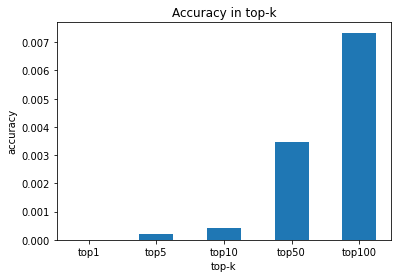

In [10]:
# 棒グラフにおけるx軸のラベルを定義
label = list(map(lambda tmp: "top" + str(tmp), topk))
# 棒グラフのx軸の値（図を整えるために定義）
x_range = [1, 2, 3, 4, 5]

# 図示する
plt.bar(x_range, height=y, width=0.5, tick_label=label)  # 棒のラベルづけと幅の変更
plt.title("Accuracy in top-k")
plt.xlabel("top-k")
plt.ylabel("accuracy");

In [11]:
# top-1、５、１０…とrmseを計算していく
# accuracyの値を保持するリストを定義
y = []

for k in topk:
  # top-k個分ループする
  # 各top-kでaccuracyを算出
  rmse = np.sqrt(mean_squared_error(original_sorted[0:k], pred_sorted[0:k]))
  y.append(rmse)
  print(rmse)
  # print(f"top-{k} accuracy : {accuracy}")

3.491251699931521
1.8394723245535687
1.8608163600053462
1.092840714473005
1.1175596845997287


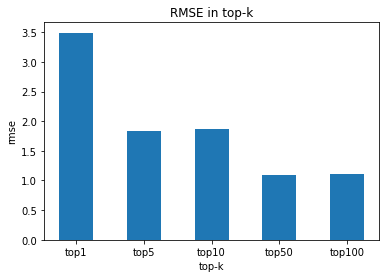

In [12]:
# 棒グラフにおけるx軸のラベルを定義
label = list(map(lambda tmp: "top" + str(tmp), topk))
# 棒グラフのx軸の値（図を整えるために定義）
x_range = [1, 2, 3, 4, 5]

# 図示する
plt.bar(x_range, height=y, width=0.5, tick_label=label)  # 棒のラベルづけと幅の変更
plt.title("RMSE in top-k")
plt.xlabel("top-k")
plt.ylabel("rmse");

#### Predict rating
###### テストデータを用いて、評価を予測する

In [13]:
## ユーザーとアイテムの評価を予測する
    # 引数について
    # X_test_update: 列User_id、行Item_id
    # 戻り値について
    # 全てのユーザーの評価予測を含むリスト、入力Xと同じ順序のアイテム
    # pred: 全てのユーザーの評価予測を含むリスト
pred = matrix_fact.predict(X_test_update)

    ## sklearnを用いて、MSEとRMSEを計算する
r2 = r2_score(y_test_update, pred)
mae = mean_absolute_error(y_test_update, pred)
rmse = np.sqrt(mean_squared_error(y_test_update, pred))
print(f"\nTest R^2: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}\n")


Test R^2: 0.2623
Test MAE: 0.8045
Test RMSE: 1.0030



#### Recommend to input user_id
###### 入力されたユーザーIDに対して、レコメンドをする

In [105]:
### Get recommendations
user = input('Enter the user_id: ')
items_known = X_train_initial.query("user_id == @user")["item_id"]
recommend_data = matrix_fact.recommend(user=user, items_known=items_known)

Enter the user_id: 200


In [106]:
recommend_data['item_id'] = recommend_data['item_id'].astype(str)

In [107]:
recommend_data = pd.merge(recommend_data, title_data, on='item_id')
recommend_data = recommend_data[['title', 'rating_pred']]
recommend_data

,title,rating_pred
0,"Shawshank Redemption, The (1994)",4.367365
1,"Usual Suspects, The (1995)",4.323328
2,"Godfather, The (1972)",4.306841
3,Rear Window (1954),4.208426
4,L.A. Confidential (1997),4.158481
5,Good Will Hunting (1997),4.157258
6,To Kill a Mockingbird (1962),4.148391
7,Fargo (1996),4.134336
8,"Close Shave, A (1995)",4.131095
9,Citizen Kane (1941),4.112576
